In [7]:
# import sys  
# from pathlib import Path
# sys.path[0] = str(Path(sys.path[0]).parent)
# print(sys.path)

In [1]:
# Imports

from loguru import logger
from collections import defaultdict
from src.outlier_detection_methods import FewShotDetector, NaiveAggregator, local_knn
from src.utils.utils import (
    set_random_seed, load_model, merge_from_dict
)
from src.augmentations import __dict__ as AUGMENTATIONS
from typing import Dict
from types import SimpleNamespace
import yaml
import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid
from src.utils.data_fetchers import get_task_loader, get_test_features
import torch
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn

In [2]:
# Variables

dataset = "mini_imagenet"
image_size = 84
n_way = 5
n_shot = 1
n_query = 1
n_tasks = 1000
backbone = 'resnet12'
training = 'feat'

In [3]:
# Setup

logger.info("Loading data...")
data_loader = get_task_loader(dataset,
                              image_size,
                              n_way,
                              n_shot,
                              n_query,
                              n_tasks,
                              split="test",
                              n_workers=0)

2022-02-03 20:34:19.030 | INFO     | __main__:<module>:3 - Loading data...
100%|██████████| 12000/12000 [00:00<00:00, 2826509.13it/s]


In [4]:
logger.info("Building model...")
weights = Path('data') / 'models' / f'{backbone}_{dataset}_{training}.pth'
feature_extractor = load_model(backbone=backbone,
                               weights=weights,
                               dataset_name=dataset,
                               device='cuda')
feature_extractor.eval()

logger.info("Loading mean/std from base set ...")

2022-02-03 20:34:19.271 | INFO     | __main__:<module>:1 - Building model...
2022-02-03 20:34:19.272 | INFO     | src.utils.utils:load_model:110 - Fetching data...
100%|██████████| 38400/38400 [00:00<00:00, 2792663.35it/s]
2022-02-03 20:34:20.101 | INFO     | src.utils.utils:load_model:113 - Building model...
2022-02-03 20:34:22.845 | INFO     | __main__:<module>:9 - Loading mean/std from base set ...


Loaded weights from data/models/resnet12_mini_imagenet_feat.pth
Missing keys []
Unexpected keys []


In [5]:
def plot_grid(images: Tensor):
    fig = plt.figure(figsize=(15, 75))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )
    std = torch.Tensor([0.229, 0.224, 0.225]).to(images.device).view(3, 1, 1)
    mean = torch.Tensor([0.485, 0.456, 0.406]).to(images.device).view(3, 1, 1)
    shifted = images * std + mean
    for ax, im in zip(grid, shifted):
        # Iterating over the grid returns the Axes.
        ax.imshow(im.permute(1, 2, 0))
        
def gram(t1: Tensor, t2: Tensor):
    """
    t1: [N1, d]
    t2: [N2, d]
    returns: [N1, N2]
    """
    assert len(t1.size()) == 2, "Only accepts pooled images"
#     t1 = F.normalize(t1, dim=1)
#     t2 = F.normalize(t2, dim=1)
    return torch.cdist(t1, t2) ** 2

In [67]:
def convolve_feature_maps(support: Tensor, query: Tensor):
    """
    map_1: [Ns, c, h, w]
    map_2: [Nq, c, h, w]
    returns [Nq, Ns, L, h', w']
    """
    support = F.normalize(support, dim=1)
    query = F.normalize(query, dim=1)
    N, c, h, w = support.size()
    kh = kw = 3
    fold_params = dict(kernel_size=(kh, kw), stride=1, dilatation=2)
    unfold = nn.Unfold(**fold_params)
    unfold_map1 = unfold(support) # [N, c*kw*kh, L]
    kernels = unfold_map1.view(N, c, kh, kh, -1).permute(0, 4, 1, 2, 3) # [Ns, L, c, kw, kh]
    conv_results = []
    for kernel in kernels:
        conv_results.append(F.conv2d(query, kernel)) # [Nq, L, h', w']
    return torch.stack(conv_results, 1) # [Nq, Ns, L, h', w']
    

### Checking map dimensions

In [68]:
# Just checking maps dimensions
layers = [f'{i}_0' for i in range(1, 5)]
with torch.no_grad():
    for i, (support, support_labels, query, query_labels, _) in tqdm(enumerate(data_loader)):        
        feat_s = feature_extractor(support.cuda(), layers)
        feat_q = feature_extractor(support.cuda(), layers)
        break
        
for layer in feat_s:
    logger.info(f"Layer {layer} of shape: {feat_s[layer].size()}")

0it [00:00, ?it/s]
2022-02-03 21:00:54.004 | INFO     | __main__:<module>:10 - Layer 1_0 of shape: torch.Size([5, 64, 84, 84])
2022-02-03 21:00:54.004 | INFO     | __main__:<module>:10 - Layer 2_0 of shape: torch.Size([5, 160, 42, 42])
2022-02-03 21:00:54.005 | INFO     | __main__:<module>:10 - Layer 3_0 of shape: torch.Size([5, 320, 21, 21])
2022-02-03 21:00:54.005 | INFO     | __main__:<module>:10 - Layer 4_0 of shape: torch.Size([5, 640, 10, 10])


### Trying this convolution idea

In [69]:
layer = "3_1"
id_scores = []
ood_scores = []
with torch.no_grad():
    for i, (support, support_labels, query, query_labels, _) in tqdm(enumerate(data_loader)):        
        feat_s = feature_extractor(support.cuda(), layer)[layer]
        feat_q = feature_extractor(query.cuda(), layer)[layer]
        convolved_res = convolve_feature_maps(feat_s, feat_q) # [Nq, Ns, L, h', w']
        similarity_scores = convolved_res.view(feat_q.size(0), -1).max(1).values
        id_scores.append(similarity_scores[:n_way * n_query])
        ood_scores.append(similarity_scores[n_way * n_query:])
        if i >= 100:
            break    

0it [00:00, ?it/s]


TypeError: __init__() got an unexpected keyword argument 'dilatation'

(array([ 3.,  0.,  4.,  1.,  0.,  1.,  4.,  1.,  5.,  7.,  6.,  6.,  1.,
         6.,  8.,  7., 14.,  9., 10., 12., 11., 13.,  8., 14.,  7., 13.,
        14., 11., 13., 16., 17., 18., 17., 10., 17.,  9., 13.,  9., 12.,
         8.,  3.,  8.,  7.,  6.,  8.,  9.,  6.,  9.,  3., 12.,  5.,  5.,
         4.,  7.,  5.,  4.,  5.,  3.,  1.,  3.,  4.,  1.,  4.,  2.,  3.,
         1.,  1.,  2.,  2.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  1.,  3.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  2.,  0.,  2.]),
 array([4.22735  , 4.2657137, 4.304077 , 4.3424406, 4.3808036, 4.419167 ,
        4.4575305, 4.495894 , 4.5342574, 4.572621 , 4.6109843, 4.6493473,
        4.687711 , 4.726074 , 4.7644377, 4.802801 , 4.8411646, 4.879528 ,
        4.917891 , 4.9562545, 4.994618 , 5.0329814, 5.071345 , 5.1097083,
        5.148072 , 5.1864347, 5.224798 , 5.2631617, 5.301525 , 5.3398886,
        5.378252 , 5.4166155, 5.454979 , 5.493342 , 5.5317054, 5

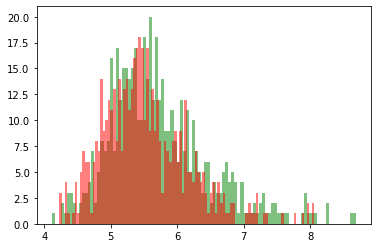

In [66]:
plt.hist(torch.cat(id_scores).cpu().numpy(), bins=100, facecolor='g', alpha=0.5)
plt.hist(torch.cat(ood_scores).cpu().numpy(), bins=100, facecolor='r', alpha=0.5)